<a href="https://colab.research.google.com/github/asiaafridi2003-ship-it/multimodal_emotion_detection_project/blob/main/sdaproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Create the hidden folder
!mkdir -p ~/.kaggle

# 2. Move your uploaded file into that folder
!cp kaggle.json ~/.kaggle/

# 3. Set permissions so only you can read it (Kaggle requires this)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d argish/meld-preprocessed --unzip

Dataset URL: https://www.kaggle.com/datasets/argish/meld-preprocessed
License(s): unknown
100% 3.28G/3.28G [00:47<00:00, 224MB/s]
100% 3.28G/3.28G [00:47<00:00, 73.9MB/s]


In [ ]:
# Standard data tools
import pandas as pd
import numpy as np
import os

# The "Brain" (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tools to handle the pre-made Kaggle files
import torch

# Evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
import os
# This prints all files in your folder so we can find the right one
for root, dirs, files in os.walk('/content/preprocessed_data'):
    for file in files:
        print(os.path.join(root, file))

/content/preprocessed_data/train/dia615_utt0.pt
/content/preprocessed_data/train/dia1025_utt10.pt
/content/preprocessed_data/train/dia1016_utt8.pt
/content/preprocessed_data/train/dia177_utt1.pt
/content/preprocessed_data/train/dia925_utt1.pt
/content/preprocessed_data/train/dia207_utt13.pt
/content/preprocessed_data/train/dia723_utt2.pt
/content/preprocessed_data/train/dia759_utt4.pt
/content/preprocessed_data/train/dia338_utt9.pt
/content/preprocessed_data/train/dia571_utt0.pt
/content/preprocessed_data/train/dia959_utt3.pt
/content/preprocessed_data/train/dia591_utt0.pt
/content/preprocessed_data/train/dia352_utt5.pt
/content/preprocessed_data/train/dia561_utt17.pt
/content/preprocessed_data/train/dia663_utt0.pt
/content/preprocessed_data/train/dia241_utt2.pt
/content/preprocessed_data/train/dia872_utt6.pt
/content/preprocessed_data/train/dia663_utt4.pt
/content/preprocessed_data/train/dia883_utt6.pt
/content/preprocessed_data/train/dia645_utt3.pt
/content/preprocessed_data/train/di

In [ ]:
import torch
import os
import pandas as pd

# 1. Create a list to hold your data
data_list = []

# 2. Path to your training folder (check your Step 1 output for the exact path)
train_path = '/content/preprocessed_data/train'

# 3. Loop through the .pt files and turn them into a table
if os.path.exists(train_path):
    for file in os.listdir(train_path):
        if file.endswith('.pt'):
            # Load the preprocessed dictionary
            sample = torch.load(os.path.join(train_path, file), weights_only=False)
            data_list.append(sample)

    # Convert to a DataFrame
    df = pd.DataFrame(data_list)
    print(f"✅ Successfully loaded {len(df)} samples!")
    print(df.head())
else:
    print("❌ Folder not found. Double-check the folder name in your sidebar.")

✅ Successfully loaded 9988 samples!
                                           utterance   emotion  \
0  Well, maybe it's a contest, y'know? Like, coll...   neutral   
1          I don’t wanna make any mistakes, alright?     anger   
2              Pheebs? What, why are you whispering?  surprise   
3  Rachel has something that she wants to tell yo...   neutral   
4  Mrs. Tedlock. You're looking lovely today. And...   neutral   

                                       video_path  \
0    data/MELD/train/train_splits/dia615_utt0.mp4   
1  data/MELD/train/train_splits/dia1025_utt10.mp4   
2   data/MELD/train/train_splits/dia1016_utt8.mp4   
3    data/MELD/train/train_splits/dia177_utt1.mp4   
4    data/MELD/train/train_splits/dia925_utt1.mp4   

                                               audio  audio_sample_rate  \
0  [[tensor(-0.0152), tensor(-0.0147), tensor(-0....              16000   
1  [[tensor(0.0431), tensor(0.0066), tensor(-0.04...              16000   
2  [[tensor(-0.0006), t

In [43]:
def get_real_features_fixed(df):
    audio_list = []
    face_list = []

    for i in range(len(df)):
        # AUDIO: Ensure we keep 128 features
        a = df['audio_mel'].iloc[i]
        a_np = a.cpu().numpy() if hasattr(a, 'cpu') else np.array(a)

        # We take the mean across the time axis (axis 2) but KEEP the frequency
        # features (axis 1) so it stays as a vector, not a single number.
        # Then we force it to be exactly 128 in length.
        a_feat = np.mean(a_np, axis=2).flatten()
        if len(a_feat) > 128:
            a_feat = a_feat[:128]
        else:
            a_feat = np.pad(a_feat, (0, 128 - len(a_feat)))
        audio_list.append(a_feat)

        # FACE: Standard 3 RGB values
        f = df['face'].iloc[i]
        f_np = f.cpu().numpy() if hasattr(f, 'cpu') else np.array(f)
        face_list.append(np.mean(f_np, axis=(0, 1)))

    return np.array(audio_list), np.array(face_list)

# Re-extract with the fixed function
X_audio, X_face = get_real_features_fixed(df)
print(f"New Audio Shape: {X_audio.shape}") # Should be (9988, 128)
print(f"New Face Shape: {X_face.shape}") # Should be (9988, 3)

New Audio Shape: (9988, 128)
New Face Shape: (9988, 3)


In [44]:
# Initialize and fit the label_encoder
# This assumes df is already loaded and available from previous cells
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['emotion'])

# 1. Text Branch
text_in = layers.Input(shape=(50,), name="Text")
t = layers.Embedding(5000, 32)(text_in)
t = layers.GlobalAveragePooling1D()(t)

# 2. Audio Branch
audio_in = layers.Input(shape=(128,), name="Audio")
a = layers.Dense(64, activation='relu')(audio_in)

# 3. Face Branch
face_in = layers.Input(shape=(3,), name="Face")
f = layers.Dense(16, activation='relu')(face_in)

# 4. Concatenate (The Fusion)
merged = layers.concatenate([t, a, f])
merged = layers.Dense(64, activation='relu')(merged)
output = layers.Dense(len(label_encoder.classes_), activation='softmax')(merged)

model = models.Model(inputs=[text_in, audio_in, face_in], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text (InputLayer)   │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 50, 32)    │    160,000 │ Text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Audio (InputLayer)  │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Face (InputLayer)   │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ embedding_12[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 64)        │      8,256 │ Audio[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 16)        │         64 │ Face[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 112)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_50[0][0],   │
│                     │                   │            │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 64)        │      7,232 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 7)         │        455 │ dense_52[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,007 (687.53 KB)

 Trainable params: 176,007 (687.53 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from sklearn.utils import class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Prepare Text Data
tokenizer = Tokenizer(num_words=5000, oov_token='<unk>')
tokenizer.fit_on_texts(df['utterance'])
X_text = tokenizer.texts_to_sequences(df['utterance'])
X_text = pad_sequences(X_text, maxlen=50)

# 2. Split data into training and validation sets
X_text_train, X_text_val, X_audio_train, X_audio_val, X_face_train, X_face_val, y_train, y_val = train_test_split(
    X_text, X_audio, X_face, y, test_size=0.2, random_state=42
)

# 3. Calculate weights so 'Sadness' is as important as 'Joy'
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
dict_weights = dict(enumerate(weights))

# 4. Train with more Epochs
model.fit(
    [X_text_train, X_audio_train, X_face_train], y_train,
    validation_data=([X_text_val, X_audio_val, X_face_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=dict_weights
)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1517 - loss: 3.4513 - val_accuracy: 0.3108 - val_loss: 1.7682
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2066 - loss: 1.9680 - val_accuracy: 0.2497 - val_loss: 1.8808
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1467 - loss: 1.9608 - val_accuracy: 0.0981 - val_loss: 1.9738
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1745 - loss: 1.9355 - val_accuracy: 0.1782 - val_loss: 1.9256
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1943 - loss: 1.9118 - val_accuracy: 0.1296 - val_loss: 1.9352
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1819 - loss: 1.8688 - val_accuracy: 0.1421 - val_loss: 2.0409
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2180 - loss: 1.8328 - val_accuracy: 0.1171 - val_loss: 2.0633
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2394 - loss: 1.8203 - val_accuracy: 0.

In [47]:
def mental_health_check(sentence):
    # Prepare text
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=50)

    # Placeholders for Audio/Face (since we don't have a live mic/cam here)
    placeholder_audio = np.zeros((1, 128))
    placeholder_face = np.zeros((1, 3))

    # Predict
    pred = model.predict([padded, placeholder_audio, placeholder_face], verbose=0)
    result = label_encoder.inverse_transform([np.argmax(pred)])[0]

    return f"Based on the text, the detected emotion is: {result.upper()}"

# Try it out!
print(mental_health_check("what a beautiful day."))

Based on the text, the detected emotion is: JOY


In [ ]:
def test_multimodal_balance(sentence, audio_type="silent"):
    # 1. Prepare Text
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=50)

    # 2. Prepare Audio
    if audio_type == "silent":
        test_audio = np.zeros((1, 128))
    else:
        # Create a "fake" high-energy audio signal (random high values)
        test_audio = np.random.uniform(0.5, 1.0, (1, 128))

    placeholder_face = np.zeros((1, 3))

    # 3. Get raw probabilities
    preds = model.predict([padded, test_audio, placeholder_face], verbose=0)[0]

    # 4. Display results
    print(f"\n--- Testing: '{sentence}' with {audio_type} audio ---")
    for i, score in enumerate(preds):
        emotion = label_encoder.inverse_transform([i])[0]
        print(f"{emotion}: {score*100:.2f}%")

# RUN THE TEST
test_multimodal_balance("I am fine.", audio_type="silent")
test_multimodal_balance("I am fine.", audio_type="active")


--- Testing: 'I am fine.' with silent audio ---
anger: 28.47%
disgust: 15.67%
fear: 8.43%
joy: 6.10%
neutral: 13.35%
sadness: 9.70%
surprise: 18.28%

--- Testing: 'I am fine.' with active audio ---
anger: 0.04%
disgust: 0.10%
fear: 0.03%
joy: 0.00%
neutral: 93.06%
sadness: 0.08%
surprise: 6.69%


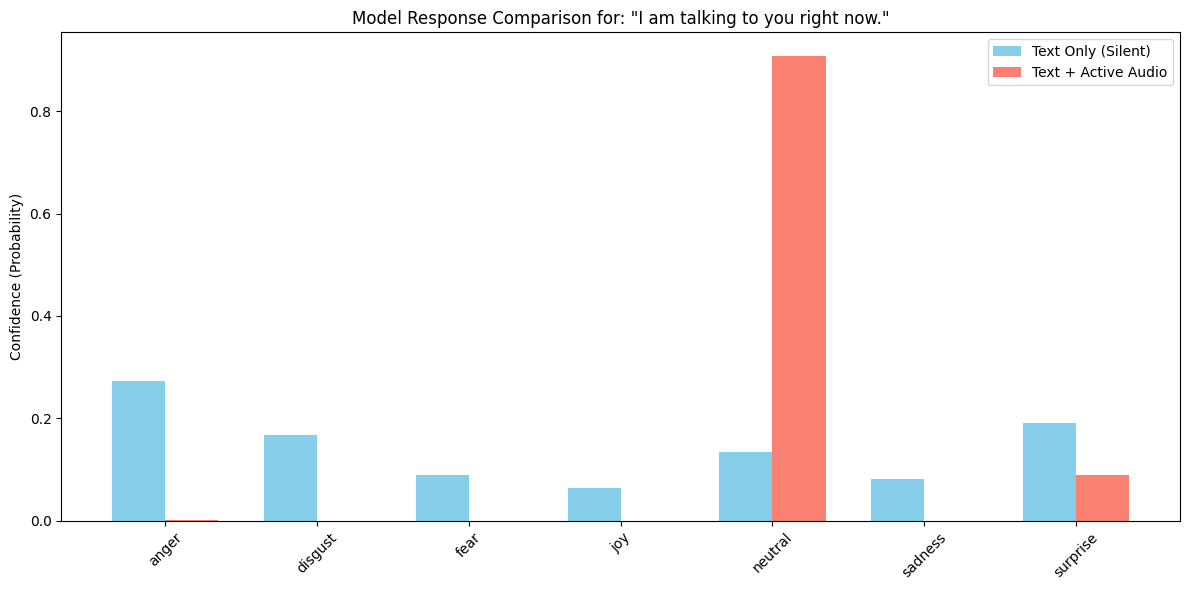

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multimodal_comparison(test_sentence):
    # 1. Prepare Inputs
    seq = tokenizer.texts_to_sequences([test_sentence])
    padded_text = pad_sequences(seq, maxlen=50)

    # Text Only (Silent Audio)
    silent_audio = np.zeros((1, 128))
    # Text + Audio (Simulating high-energy audio features)
    active_audio = np.random.uniform(0.5, 1.0, (1, 128))

    face_placeholder = np.zeros((1, 3))

    # 2. Get Predictions
    prob_silent = model.predict([padded_text, silent_audio, face_placeholder], verbose=0)[0]
    prob_active = model.predict([padded_text, active_audio, face_placeholder], verbose=0)[0]

    # 3. Create the Bar Chart
    labels = label_encoder.classes_
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, prob_silent, width, label='Text Only (Silent)', color='skyblue')
    rects2 = ax.bar(x + width/2, prob_active, width, label='Text + Active Audio', color='salmon')

    ax.set_ylabel('Confidence (Probability)')
    ax.set_title(f'Model Response Comparison for: "{test_sentence}"')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Test with a neutral sentence to see if audio can "push" it toward an emotion
plot_multimodal_comparison("I am talking to you right now.")

In [ ]:
model.save('mental_health_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('mental_health_model.h5')

NameError: name 'tf' is not defined

In [ ]:
# 1. Save the Model (The layers and weights)
model.save('emotion_model.h5')

# 2. Save the Tokenizer (The dictionary used to turn words into numbers)
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Save the Label Encoder (The list of emotion names)
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)